In [ ]:
from tensorflow.keras.models import Model, Sequential 
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization, Dropout
from tensorflow.keras import backend as K 
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras import utils 
import matplotlib.pyplot as plt 
from tensorflow.keras.preprocessing import image 
import numpy as np 
import pandas as pd 
from PIL import Image 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler # модуль для стандартизации данных

from tensorflow.keras.preprocessing.text import Tokenizer # Методы для работы с текстами и преобразования их в последовательности
from tensorflow.keras.preprocessing.sequence import pad_sequences # Метод для работы с последовательностями
from sklearn.preprocessing import LabelEncoder # Метод кодирования тестовых лейблов

import os 
import time

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
df_test = pd.read_csv('/content/test.csv')
df_train = pd.read_csv('/content/train.csv')

In [ ]:
df_test

,Unnamed: 0,Smiles
0,0,COC(=O)Nc1ccc(-c2nc(N3CCOCC3)c3cnn(C4CCN(Cc5cc...
1,1,O=Cc1cn(Cc2ccc(Cl)cc2)c2ccccc12
2,2,NC(CO)C(=O)NNCc1ccc(O)c(O)c1O
3,3,Nc1nc(=O)n([C@H]2C[C@H](O)[C@@H](CO)O2)cc1Cl
4,4,Nc1ccc(C(=O)Nc2cccc(-c3nc(N4CCOCC4)c4oc5ncccc5...
...,...,...
1609,1609,NS(=O)(=O)c1cc2c(cc1Cl)NC(C1CC3C=CC1C3)NS2(=O)=O
1610,1610,Cc1cccc(Nc2ccncc2S(=O)(=O)NC(=O)NC(C)C)c1
1611,1611,CCCC(=O)O[C@]1(C(=O)CO)CC[C@H]2[C@@H]3CCC4=CC(...
1612,1612,CN(C)c1cccc(Oc2cnc(Nc3cccc(O)c3)nc2)c1


In [ ]:
df_train

,Unnamed: 0,Smiles,Active
0,0,COc1ccc2[nH]cc(CCN)c2c1,False
1,1,CCCN1CCC[C@H](c2cccc(O)c2)C1.Cl,False
2,2,O=C(NO)c1cnc(N2CCN(S(=O)(=O)c3ccc4ccccc4c3)CC2...,False
3,3,Nc1cccc(CNC(=O)c2ccc(Oc3ccc(OCc4cccc(F)c4)cc3)...,False
4,4,Fc1ccccc1CNCc1ccc(-c2ccnc3[nH]ccc23)cc1,False
...,...,...,...
5552,5552,O=C(Oc1ccc([N+](=O)[O-])cc1)N1CCC(C(O)(c2ccc3c...,False
5553,5553,Nc1nonc1/C(=N/O)Nc1ccc(F)c(Br)c1,False
5554,5554,Oc1cccc2cccnc12,False
5555,5555,OC(c1ccc(-c2ccc(CN3CCN(Cc4ccncc4)CC3)cc2)c(F)c...,False


In [ ]:
# оцениваю на пропуски
df_train.isna().sum()

Unnamed: 0    0
Smiles        0
Active        0
dtype: int64

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5557 entries, 0 to 5556
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5557 non-null   int64 
 1   Smiles      5557 non-null   object
 2   Active      5557 non-null   bool  
dtypes: bool(1), int64(1), object(1)
memory usage: 92.4+ KB


In [ ]:
df_train.describe()

,Unnamed: 0
count,5557.000000
mean,2778.000000
std,1604.312054
min,0.000000
25%,1389.000000
50%,2778.000000
75%,4167.000000
max,5556.000000


#Автокодировщик

**Представляю Smiles в виде вектора**

In [ ]:
!pip install kora -q
import kora.install.rdkit # по-дургому не запускалось
from rdkit import Chem
from rdkit.Chem import AllChem

     |████████████████████████████████| 57 kB 3.5 MB/s 
     |████████████████████████████████| 56 kB 3.8 MB/s 


In [ ]:
# загружаю датасет
df_train_new = pd.read_csv('/content/train.csv', index_col = 0)
df_train_new.head()

,Smiles,Active
0,COc1ccc2[nH]cc(CCN)c2c1,False
1,CCCN1CCC[C@H](c2cccc(O)c2)C1.Cl,False
2,O=C(NO)c1cnc(N2CCN(S(=O)(=O)c3ccc4ccccc4c3)CC2...,False
3,Nc1cccc(CNC(=O)c2ccc(Oc3ccc(OCc4cccc(F)c4)cc3)...,False
4,Fc1ccccc1CNCc1ccc(-c2ccnc3[nH]ccc23)cc1,False


In [ ]:
# df активные молекулы
df_train_True = df_train_new[df_train_new.Active==True]
df_train_True.head()

,Smiles,Active
17,Nc1ccc(O)c2ncccc12,True
38,C[C@H]1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)...,True
52,Cl.NCCc1cc(O)c(O)cc1O,True
111,Cc1ccc(-n2sc(=O)n(Cc3ccc(F)cc3)c2=O)cc1,True
122,Oc1cc2c(cc1C(c1ccc(C(F)(F)F)cc1)N1CCOCC1)OCO2,True


In [ ]:
# df неактивные молекулы
df_train_False = df_train_new[df_train_new.Active==False]
df_train_False.head()

,Smiles,Active
0,COc1ccc2[nH]cc(CCN)c2c1,False
1,CCCN1CCC[C@H](c2cccc(O)c2)C1.Cl,False
2,O=C(NO)c1cnc(N2CCN(S(=O)(=O)c3ccc4ccccc4c3)CC2...,False
3,Nc1cccc(CNC(=O)c2ccc(Oc3ccc(OCc4cccc(F)c4)cc3)...,False
4,Fc1ccccc1CNCc1ccc(-c2ccnc3[nH]ccc23)cc1,False


In [ ]:
# собираю значения Smiles неактивных молекул в лист
s_inactive = []
for i in df_train_False['Smiles']:
  s_inactive.append(i)

print('Длинна s_inactive:', len(s_inactive))
print("Пример значения из s_inactive:", s_inactive[1])

Длинна s_inactive: 5351
Пример значения из s_inactive: CCCN1CCC[C@H](c2cccc(O)c2)C1.Cl


In [ ]:
# активные молекулы
s_active = []
for i in df_train_True['Smiles']:
  s_active.append(i)

print('Длинна s_active:', len(s_active))
print("Пример значения из s_active:", s_active[1])

Длинна s_active: 206
Пример значения из s_active: C[C@H]1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23


In [ ]:
# функция перефода smiles в вектор 0 и 1
def get_morgan_fingerprint(smiles: str, radius=2, nBits=4096): # сделал nBits=4096
    mol = Chem.MolFromSmiles(smiles)
    morgan_fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits)
    return (list(morgan_fp))

In [ ]:
# для активных
smal_active = []
for i in s_active:
  sm = get_morgan_fingerprint(i)      # получаю вектор из smiles
  smal_active.append(sm)
smal_active = np.array(smal_active)   # преобразую в numpy

print(f"Количество молекул активных: {len(smal_active)}\nДлинна вектора одной молекулы: {len(smal_active[77])}")
print(f'Пример вектора smal_active: {smal_active[77]}')
print(f'Размер массива smal_active: {smal_active.shape}')

Количество молекул активных: 206
Длинна вектора одной молекулы: 4096
Пример вектора smal_active: [0 0 0 ... 0 0 0]
Размер массива smal_active: (206, 4096)


In [ ]:
# для неактивных
smal_inactive = []
for i in s_inactive:
  sm = get_morgan_fingerprint(i)       # получаю вектор из smiles
  smal_inactive.append(sm)
smal_inactive = np.array(smal_inactive)# преобразую в numpy

In [ ]:
# смотрю максимальные и минимальные значения
smal_inactive.max(), smal_inactive.min(), 

(1, 0)

In [ ]:
RANDOM_SEED = 42 # задаем случайное значение

# берём неактивные молекулы разбиваем на train_test(только 'X')
X_train, X_test = train_test_split(smal_inactive, test_size=0.2, random_state=RANDOM_SEED)

In [ ]:
# размеры
X_train.shape, X_test.shape, smal_active.shape

((4280, 4096), (1071, 4096), (206, 4096))

In [ ]:
'''
# создаю Y_test для тестовой и Y_smal_active для активных молекул
Y_test = np.zeros(1071)
Y_smal_active = np.ones(206)

# размеры
Y_test.shape, Y_smal_active.shape
'''

((1071,), (206,))

In [ ]:
# Добавляю все активные молекулы в тестовый набор данных для того, чтобы потом сравнивать mse после обучения
X_test = np.concatenate((X_test, smal_active))
Y_test = np.concatenate((Y_test, Y_smal_active))

# размеры
X_test.shape, Y_test.shape

((1277, 4096), (1277,))

**Нейронная сеть**

In [ ]:
def Smiles_Autoencoder(): 
  dataSize = 4096 # размер входного слоя
  dataInput = Input(shape=(dataSize, )) # задаем эти размеры как входные в сеть
  
  x = Dense(10, activation='relu')(dataInput) # пропускаем через полносвязный слой размером 10
  x = Dense(dataSize, activation='sigmoid')(x) # выход это полносвязный слой размером 4096
  
  autoencoder = Model(inputs=dataInput, outputs=x) # собрали модель 
  
  autoencoder.compile(optimizer=Adam(learning_rate=0.0001), loss='mse') # компилируем модель также, с выбором оптимайзера и среднеквадратичной ошибки
  
  return autoencoder 

In [ ]:
model = Smiles_Autoencoder()
history = model.fit(X_train, X_train,
                    epochs=100,
                    batch_size=12) # загружаем данные в модель(X_train'ы) и обучаем

Epoch 1/100
357/357 [==============================] - 2s 3ms/step - loss: 0.1992
Epoch 2/100
357/357 [==============================] - 1s 3ms/step - loss: 0.0630
Epoch 3/100
357/357 [==============================] - 1s 3ms/step - loss: 0.0261
Epoch 4/100
357/357 [==============================] - 1s 3ms/step - loss: 0.0175
Epoch 5/100
357/357 [==============================] - 1s 4ms/step - loss: 0.0143
Epoch 6/100
357/357 [==============================] - 1s 4ms/step - loss: 0.0127
Epoch 7/100
357/357 [==============================] - 1s 3ms/step - loss: 0.0118
Epoch 8/100
357/357 [==============================] - 1s 4ms/step - loss: 0.0111
Epoch 9/100
357/357 [==============================] - 1s 3ms/step - loss: 0.0107
Epoch 10/100
357/357 [==============================] - 1s 4ms/step - loss: 0.0104
Epoch 11/100
357/357 [==============================] - 1s 4ms/step - loss: 0.0102
Epoch 12/100
357/357 [==============================] - 1s 3ms/step - loss: 0.0101
Epoch 13/100


**Проверка результата**

In [ ]:
predictions = model.predict(X_test) # делаем предсказание по X_test на неактивных и активных молекулах
predictions.shape

(1277, 4096)

In [ ]:
predictions[9]

array([1.0093013e-04, 4.3236741e-05, 2.3633594e-02, ..., 2.5005715e-05,
       2.5241254e-05, 2.0602742e-05], dtype=float32)

In [ ]:
# считаю mse
mse = np.mean(np.power(X_test - predictions, 2), axis=1)

In [ ]:
mse_Inactivel = mse[:1071] # неактивные. Так как при concatenate X_test и smal_activeдо 1071 были неактивные, а после 1071 активные.
mse_Active = mse[1071:] # активные

# размеры
print(mse_Inactivel.shape)
print(mse_Active.shape)

(1071,)
(206,)


In [ ]:
print("Минимальная ошибка неактивных молекул:", round(min(mse_Inactivel),4)) #
print("Максимальная ошибка неактивных молекул:", round(max(mse_Inactivel),4)) #
print("Средняя ошибка неактивных молекул:", round(sum(mse_Inactivel) / len(mse_Inactivel),8)) # средняя ошибка

Минимальная ошибка неактивных молекул: 0.001
Максимальная ошибка неактивных молекул: 0.0198
Средняя ошибка неактивных молекул: 0.0074242


In [ ]:
print("Минимальная ошибка активных молекул:", round(min(mse_Active),4)) #
print("Максимальная ошибка активных молекул:", round(max(mse_Active),4)) #
print("Средняя ошибка активных молекул:", round(sum(mse_Active) / len(mse_Active),8)) # средняя ошибка

Минимальная ошибка активных молекул: 0.0023
Максимальная ошибка активных молекул: 0.0203
Средняя ошибка активных молекул: 0.00701959


Я рассчитывал на то, что mse будет больше на активных молекулах, на которых сеть НЕ обучалась. Но по факту средняя ошибка на активных молекулах получилась практически одинаковая, чуть меньше. Активные => 0.0070, а неактивные => 0.0074

In [ ]:
def getAccByBias(bias): # функция будет принимать какое то пороговое значение
  isInactive = mse_Inactivel > bias # если ошибка больше порога - то неактивная
  isActive = mse_Active < bias # если ошибка меньше порога - то активная

  accInactive = sum(isInactive) / len(isInactive) # вычисляем процент неактивных
  accActive = sum(isActive) / len(isActive) # вычисляем процент активных

  print("Распознано неактивных молекул: ", round(100*accInactive), "%", sep="")
  print("Распознано активных молекул: ", round(100*accActive), "%", sep="")
  print("Средняя точность распознавания: ", round(50*(accInactive + accActive)), "%", sep="")

In [ ]:
getAccByBias(0.007)

Распознано неактивных молекул: 51%
Распознано активных молекул: 54%
Средняя точность распознавания: 53%


## Submit

In [ ]:
df_test = pd.read_csv('/content/test.csv', index_col = 0)
df_test.head()

,Smiles
0,COC(=O)Nc1ccc(-c2nc(N3CCOCC3)c3cnn(C4CCN(Cc5cc...
1,O=Cc1cn(Cc2ccc(Cl)cc2)c2ccccc12
2,NC(CO)C(=O)NNCc1ccc(O)c(O)c1O
3,Nc1nc(=O)n([C@H]2C[C@H](O)[C@@H](CO)O2)cc1Cl
4,Nc1ccc(C(=O)Nc2cccc(-c3nc(N4CCOCC4)c4oc5ncccc5...


In [ ]:
# test
test_smiles = []
for i in df_test['Smiles']:
  test_smiles.append(i)

print('Длинна test_smiles:', len(test_smiles))
print("Пример значения из test_smiles:", test_smiles[1])

Длинна test_smiles: 1614
Пример значения из test_smiles: O=Cc1cn(Cc2ccc(Cl)cc2)c2ccccc12


In [ ]:
test = []
for i in test_smiles:
  sm = get_morgan_fingerprint(i)  # получаю вектор из smiles
  test.append(sm)
test = np.array(test)             # преобразую в numpy
test.shape

(1614, 4096)

In [ ]:
predictions_test = model.predict(test) # делаем предсказание

In [ ]:
mse_test = np.mean(np.power(test - predictions_test, 2), axis=1)

print("Минимальная ошибка молекул:", round(min(mse_test),4)) #
print("Максимальная ошибка молекул:", round(max(mse_test),4)) #
print("Средняя ошибка молекул:", round(sum(mse_test) / len(mse_test),8)) # среднюю ошибку

Минимальная ошибка молекул: 0.0009
Максимальная ошибка молекул: 0.0258
Средняя ошибка молекул: 0.00749708


In [ ]:
mse_test.shape

(1614,)

In [ ]:
# Формирую табличку 
submission = df_test
submission['Active'] = ''

for i in range(len(mse_test)):
  if mse_test[i] >= 0.007:
    submission['Active'].values[i] = 0
  else:
    submission['Active'].values[i] = 1

In [ ]:
submission

,Smiles,Active
0,COC(=O)Nc1ccc(-c2nc(N3CCOCC3)c3cnn(C4CCN(Cc5cc...,0
1,O=Cc1cn(Cc2ccc(Cl)cc2)c2ccccc12,1
2,NC(CO)C(=O)NNCc1ccc(O)c(O)c1O,1
3,Nc1nc(=O)n([C@H]2C[C@H](O)[C@@H](CO)O2)cc1Cl,1
4,Nc1ccc(C(=O)Nc2cccc(-c3nc(N4CCOCC4)c4oc5ncccc5...,0
...,...,...
1609,NS(=O)(=O)c1cc2c(cc1Cl)NC(C1CC3C=CC1C3)NS2(=O)=O,0
1610,Cc1cccc(Nc2ccncc2S(=O)(=O)NC(=O)NC(C)C)c1,0
1611,CCCC(=O)O[C@]1(C(=O)CO)CC[C@H]2[C@@H]3CCC4=CC(...,0
1612,CN(C)c1cccc(Oc2cnc(Nc3cccc(O)c3)nc2)c1,0


In [ ]:
submission.to_csv('submission.csv', index=False)

In [192]:
# соберу в функцию

def submission(df_test, bias):

  test_smiles = []
  for i in df_test['Smiles']:
    test_smiles.append(i)

  test = []
  for i in test_smiles:
    sm = get_morgan_fingerprint(i)  # получаю вектор из smiles
    test.append(sm)
  test = np.array(test)             # преобразую в numpy
  
  predictions_test = model.predict(test) # делаем предсказание
  
  mse_test = np.mean(np.power(test - predictions_test, 2), axis=1)

  # Формирую табличку 
  submission = df_test
  submission['Active'] = ''
  
  for i in range(len(mse_test)):
    if mse_test[i] >= bias:
      submission['Active'].values[i] = 0
    else:
      submission['Active'].values[i] = 1
  
  submission.to_csv('submission.csv', index=False)

   
  print('Длинна test_smiles:', len(test_smiles))
  print("Пример значения из test_smiles:", test_smiles[1])
  print("Минимальная ошибка молекул:", round(min(mse_test),4)) #
  print("Максимальная ошибка молекул:", round(max(mse_test),4)) #
  print("Средняя ошибка молекул:", round(sum(mse_test) / len(mse_test),8)) # среднюю ошибку

  return submission


##**Свертка Conv2D + Dense**

In [ ]:
X_train.shape, X_test.shape, smal_active.shape

((4280, 4096), (1277, 4096), (206, 4096))

In [ ]:
def Autoencoder_Conv2D(): 
    img_input = Input(shape=(4096,)) 

    x = Reshape((64,64,1))(img_input)

    x = Conv2D(32, (3, 3), strides=2, activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), strides=2, activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), strides=2, activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), strides=2, activation='relu', padding='same')(x)
    x = Flatten()(x) # сплющиваем в одномерный вектор - размер 4*4*256
    z = Dense(256, activation='relu')(x) # добавляем полносвязный слой
    x = Dense(4*4*256, activation='relu')(z) # и еще полносвязный слой
    x = Reshape((4,4,256))(x) # меняем размеры - картинка 4*4 , 256 ядер
    x = Conv2DTranspose(256, (3, 3), strides=2, padding='same')(x) 
    x = Conv2DTranspose(128, (3, 3), strides=2, padding='same')(x) 
    x = Conv2DTranspose(64, (3, 3), strides=2, padding='same')(x) 
    x = Conv2DTranspose(32, (3, 3), strides=2, padding='same')(x) 
    x = Conv2D(1, (3, 3), activation='relu', padding='same')(x) 
    x = Flatten()(x) # выпрямляю в вектор

    x = Dense(4096, activation='sigmoid')(x) # последний слой

    model = Model(img_input, x) 
    model.compile(optimizer='adam',
                  loss='mse') 

    return model 

In [ ]:
model_Conv2D = Autoencoder_Conv2D()
model_Conv2D.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 4096)]            0         
                                                                 
 reshape (Reshape)           (None, 64, 64, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 256)         295168    
                                                                 
 flatten (Flatten)           (None, 4096)              0   

In [ ]:
model_Conv2D = Autoencoder_Conv2D()

history = model_Conv2D.fit(X_train, X_train, epochs=10, batch_size=16) 

Epoch 1/10
268/268 [==============================] - 16s 30ms/step - loss: 0.2198
Epoch 2/10
268/268 [==============================] - 8s 29ms/step - loss: 0.1678
Epoch 3/10
268/268 [==============================] - 8s 29ms/step - loss: 0.1284
Epoch 4/10
268/268 [==============================] - 8s 29ms/step - loss: 0.0994
Epoch 5/10
268/268 [==============================] - 8s 29ms/step - loss: 0.0782
Epoch 6/10
268/268 [==============================] - 8s 29ms/step - loss: 0.0627
Epoch 7/10
268/268 [==============================] - 8s 29ms/step - loss: 0.0512
Epoch 8/10
268/268 [==============================] - 8s 29ms/step - loss: 0.0425
Epoch 9/10
268/268 [==============================] - 8s 29ms/step - loss: 0.0360
Epoch 10/10
268/268 [==============================] - 8s 29ms/step - loss: 0.0309


**Проверка**

In [ ]:
predictions = model_Conv2D.predict(X_test) # делаем предсказание по X_test на неактивных и активных молекулах
predictions.shape

(1277, 4096)

In [ ]:
# считаю mse
mse = np.mean(np.power(X_test - predictions, 2), axis=1)

mse_Inactivel = mse[:1071] # неактивные. Так как при concatenate X_test и smal_activeдо 1071 были неактивные, а после 1071 активные.
mse_Active = mse[1071:] # активные

# размеры
print(mse_Inactivel.shape)
print(mse_Active.shape)

(1071,)
(206,)


In [ ]:
print("Минимальная ошибка неактивных молекул:", round(min(mse_Inactivel),4)) #
print("Максимальная ошибка неактивных молекул:", round(max(mse_Inactivel),4)) #
print("Средняя ошибка неактивных молекул:", round(sum(mse_Inactivel) / len(mse_Inactivel),8)) # средняя ошибка
print()
print("Минимальная ошибка активных молекул:", round(min(mse_Active),4)) #
print("Максимальная ошибка активных молекул:", round(max(mse_Active),4)) #
print("Средняя ошибка активных молекул:", round(sum(mse_Active) / len(mse_Active),8)) # средняя ошибка

Минимальная ошибка неактивных молекул: 0.0237
Максимальная ошибка неактивных молекул: 0.0406
Средняя ошибка неактивных молекул: 0.02867178

Минимальная ошибка активных молекул: 0.0247
Максимальная ошибка активных молекул: 0.0386
Средняя ошибка активных молекул: 0.02819633


In [ ]:
def getAccByBias(bias): # функция будет принимать какое то пороговое значение
  isInactive = mse_Inactivel > bias # если ошибка больше порога - то неактивная
  isActive = mse_Active < bias # если ошибка меньше порога - то активная

  accInactive = sum(isInactive) / len(isInactive) # вычисляем процент неактивных
  accActive = sum(isActive) / len(isActive) # вычисляем процент активных

  print("Распознано неактивных молекул: ", round(100*accInactive), "%", sep="")
  print("Распознано активных молекул: ", round(100*accActive), "%", sep="")
  print("Средняя точность распознавания: ", round(50*(accInactive + accActive)), "%", sep="")

In [ ]:
getAccByBias(0.028)

Распознано неактивных молекул: 59%
Распознано активных молекул: 51%
Средняя точность распознавания: 55%


##**По-другому токенезирую, Tokenizer**

In [138]:
# загружаю датасет
df_train_new = pd.read_csv('/content/train.csv', index_col = 0)
df_train_new.head()

,Smiles,Active
0,COc1ccc2[nH]cc(CCN)c2c1,False
1,CCCN1CCC[C@H](c2cccc(O)c2)C1.Cl,False
2,O=C(NO)c1cnc(N2CCN(S(=O)(=O)c3ccc4ccccc4c3)CC2...,False
3,Nc1cccc(CNC(=O)c2ccc(Oc3ccc(OCc4cccc(F)c4)cc3)...,False
4,Fc1ccccc1CNCc1ccc(-c2ccnc3[nH]ccc23)cc1,False


In [142]:
# df активные молекулы
df_train_True = df_train_new[df_train_new.Active==True]

# df неактивные молекулы
df_train_False = df_train_new[df_train_new.Active==False]

In [143]:
# собираю значения Smiles неактивных молекул в лист
s_inactive = []
for i in df_train_False['Smiles']:
  s_inactive.append(i)

print('Длинна s_inactive:', len(s_inactive))
print("Пример значения из s_inactive:", s_inactive[1])

Длинна s_inactive: 5351
Пример значения из s_inactive: CCCN1CCC[C@H](c2cccc(O)c2)C1.Cl


In [144]:
# активные молекулы
s_active = []
for i in df_train_True['Smiles']:
  s_active.append(i)

print('Длинна s_active:', len(s_active))
print("Пример значения из s_active:", s_active[1])

Длинна s_active: 206
Пример значения из s_active: C[C@H]1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23


In [145]:
# все молекулы
Smiles = s_active + s_inactive
len(Smiles)

5557

In [146]:
maxWordsCount = 4096 # Определяем максимальное количество слов/индексов, учитываемое при обучении текстов

# Воспользуемся встроенной в Keras функцией Tokenizer для разбиения текста и превращения в матрицу числовых значений
# num_words=maxWordsCount - определяем максимальное количество слов/индексов, учитываемое при обучении текстов
# filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n' - избавляемся от ненужных символов
# lower=True - приводим слова к нижнему регистру
# split=' ' - разделяем слова по пробелу
# char_level=False - токенизируем по словам (Если будет True - каждый символ будет рассматриваться как отдельный токен )
tokenizer = Tokenizer(num_words=maxWordsCount, filters='', lower=False, split='', oov_token='unknown', char_level=True)

tokenizer.fit_on_texts(Smiles) # "Скармливаем" наши тексты, т.е. даём в обработку методу, который соберет словарь частотности
items = list(tokenizer.word_index.items()) # Вытаскиваем индексы слов для просмотра

In [147]:
print(items[:50]) # Посмотрим 10 самых часто встречающихся символов
print("Размер словаря", len(items)) # Длина словаря

[('unknown', 1), ('c', 2), ('C', 3), ('(', 4), (')', 5), ('O', 6), ('1', 7), ('2', 8), ('=', 9), ('@', 10), ('N', 11), ('[', 12), (']', 13), ('H', 14), ('n', 15), ('3', 16), ('F', 17), ('4', 18), ('-', 19), ('l', 20), ('S', 21), ('/', 22), ('.', 23), ('5', 24), ('+', 25), ('s', 26), ('o', 27), ('#', 28), ('\\', 29), ('B', 30), ('r', 31), ('P', 32), ('I', 33), ('a', 34), ('6', 35), ('7', 36), ('A', 37), ('8', 38), ('i', 39), ('K', 40), ('Z', 41), ('g', 42), ('M', 43), ('L', 44), ('e', 45), ('9', 46)]
Размер словаря 46


In [148]:
# Преобразовываем текст в последовательность индексов согласно частотному словарю
s_inactive_WordIndexes = tokenizer.texts_to_sequences(s_inactive) # тесты в индексы
s_active_WordIndexes = tokenizer.texts_to_sequences(s_active) # тесты в индексы

In [149]:
print("Взглянем на Smiles:")
print("Как в таблице:              ", s_inactive[1])
print("В виде последовательности индексов: ", s_inactive_WordIndexes[1], '\n')
len(s_inactive[1]), len(s_inactive_WordIndexes[1])

Взглянем на Smiles:
Как в таблице:               CCCN1CCC[C@H](c2cccc(O)c2)C1.Cl
В виде последовательности индексов:  [3, 3, 3, 11, 7, 3, 3, 3, 12, 3, 10, 14, 13, 4, 2, 8, 2, 2, 2, 2, 4, 6, 5, 2, 8, 5, 3, 7, 23, 3, 20] 



(31, 31)

In [150]:
X_tr = tokenizer.sequences_to_matrix(s_inactive_WordIndexes)
smal_active = tokenizer.sequences_to_matrix(s_active_WordIndexes)

print(X_tr.shape, smal_active.shape)       # Размер обучающей выборки, сформированной по Bag of Words
print(X_tr[0][0:100]) # Фрагмент в виде Bag of Words

(5351, 4096) (206, 4096)
[0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [162]:
RANDOM_SEED = 42

# берём неактивные молекулы разбиваем на train_test(только 'X')
X_train, X_test = train_test_split(X_tr, test_size=0.2, random_state=RANDOM_SEED)

In [163]:
X_test = np.concatenate((X_test, smal_active))
X_test.shape

(1277, 4096)

In [152]:
def Smiles_Autoencoder(): 
  dataSize = 4096 # размер входного слоя
  dataInput = Input(shape=(dataSize, )) # задаем эти размеры как входные в сеть
  
  x = Dense(10, activation='relu')(dataInput) # пропускаем через полносвязный слой размером 10
  x = Dense(dataSize, activation='sigmoid')(x) # выход это полносвязный слой размером 4096
  
  autoencoder = Model(inputs=dataInput, outputs=x) # собрали модель 
  
  autoencoder.compile(optimizer=Adam(learning_rate=0.0001), loss='mse') # компилируем модель также, с выбором оптимайзера и среднеквадратичной ошибки
  
  return autoencoder 

In [153]:
model = Smiles_Autoencoder()
model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 4096)]            0         
                                                                 
 dense_22 (Dense)            (None, 10)                40970     
                                                                 
 dense_23 (Dense)            (None, 4096)              45056     
                                                                 
Total params: 86,026
Trainable params: 86,026
Non-trainable params: 0
_________________________________________________________________


In [154]:
model = Smiles_Autoencoder()
history = model.fit(X_train, X_train,
                    epochs=100,
                    batch_size=12) # загружаем данные в модель(X_train'ы) и обучаем

Epoch 1/100
357/357 [==============================] - 2s 3ms/step - loss: 0.2214
Epoch 2/100
357/357 [==============================] - 1s 3ms/step - loss: 0.1033
Epoch 3/100
357/357 [==============================] - 1s 3ms/step - loss: 0.0356
Epoch 4/100
357/357 [==============================] - 1s 3ms/step - loss: 0.0157
Epoch 5/100
357/357 [==============================] - 1s 3ms/step - loss: 0.0088
Epoch 6/100
357/357 [==============================] - 1s 3ms/step - loss: 0.0058
Epoch 7/100
357/357 [==============================] - 1s 3ms/step - loss: 0.0042
Epoch 8/100
357/357 [==============================] - 1s 3ms/step - loss: 0.0032
Epoch 9/100
357/357 [==============================] - 1s 3ms/step - loss: 0.0026
Epoch 10/100
357/357 [==============================] - 1s 3ms/step - loss: 0.0022
Epoch 11/100
357/357 [==============================] - 1s 3ms/step - loss: 0.0019
Epoch 12/100
357/357 [==============================] - 1s 3ms/step - loss: 0.0017
Epoch 13/100


In [195]:
predictions = model.predict(X_test) # делаем предсказание по X_test на неактивных и активных молекулах
print(predictions.shape)

# считаю mse
mse = np.mean(np.power(X_test - predictions, 2), axis=1)

mse_Inactivel = mse[:1071] # неактивные. Так как при concatenate X_test и smal_activeдо 1071 были неактивные, а после 1071 активные.
mse_Active = mse[1071:] # активные

# размеры
print(mse_Inactivel.shape)
print(mse_Active.shape)

(1277, 4096)
(1071,)
(206,)


In [196]:
print("Минимальная ошибка неактивных молекул:", round(min(mse_Inactivel),4)) #
print("Максимальная ошибка неактивных молекул:", round(max(mse_Inactivel),4)) #
print("Средняя ошибка неактивных молекул:", round(sum(mse_Inactivel) / len(mse_Inactivel),8)) # средняя ошибка
print()
print("Минимальная ошибка активных молекул:", round(min(mse_Active),4)) #
print("Максимальная ошибка активных молекул:", round(max(mse_Active),4)) #
print("Средняя ошибка активных молекул:", round(sum(mse_Active) / len(mse_Active),8)) # средняя ошибка

Минимальная ошибка неактивных молекул: 0.0001
Максимальная ошибка неактивных молекул: 0.0018
Средняя ошибка неактивных молекул: 0.00031974

Минимальная ошибка активных молекул: 0.0001
Максимальная ошибка активных молекул: 0.0015
Средняя ошибка активных молекул: 0.00041945


In [197]:
def getAccByBias(bias): 
  isInactive = mse_Inactivel < bias # тут поменял знаки, так как mse неактивных меньше
  isActive = mse_Active > bias # поменял знаки

  accInactive = sum(isInactive) / len(isInactive) # вычисляем процент неактивных
  accActive = sum(isActive) / len(isActive) # вычисляем процент активных

  print("Распознано неактивных молекул: ", round(100*accInactive), "%", sep="")
  print("Распознано активных молекул: ", round(100*accActive), "%", sep="")
  print("Средняя точность распознавания: ", round(50*(accInactive + accActive)), "%", sep="")

In [198]:
getAccByBias(0.00031)

Распознано неактивных молекул: 61%
Распознано активных молекул: 57%
Средняя точность распознавания: 59%


In [201]:
# функцию submit

def submission(df_test, model, bias):

  test_smiles = []
  for i in df_test['Smiles']:
    test_smiles.append(i)

  test = []
  for i in test_smiles:
    sm = get_morgan_fingerprint(i)  # получаю вектор из smiles
    test.append(sm)
  test = np.array(test)             # преобразую в numpy
  
  predictions_test = model.predict(test) # делаем предсказание
  
  mse_test = np.mean(np.power(test - predictions_test, 2), axis=1)

  # Формирую табличку 
  submission = df_test
  submission['Active'] = ''
  
  for i in range(len(mse_test)):
    if mse_test[i] >= bias:
      submission['Active'].values[i] = 0
    else:
      submission['Active'].values[i] = 1
  
  submission.to_csv('submission.csv', index=False)

   
  print('Длинна test_smiles:', len(test_smiles))
  print("Пример значения из test_smiles:", test_smiles[1])
  print("Минимальная ошибка молекул:", round(min(mse_test),4)) #
  print("Максимальная ошибка молекул:", round(max(mse_test),4)) #
  print("Средняя ошибка молекул:", round(sum(mse_test) / len(mse_test),8)) # среднюю ошибку

  return submission

In [200]:
df_test = pd.read_csv('/content/test.csv', index_col = 0)
df_test.head()

,Smiles
0,COC(=O)Nc1ccc(-c2nc(N3CCOCC3)c3cnn(C4CCN(Cc5cc...
1,O=Cc1cn(Cc2ccc(Cl)cc2)c2ccccc12
2,NC(CO)C(=O)NNCc1ccc(O)c(O)c1O
3,Nc1nc(=O)n([C@H]2C[C@H](O)[C@@H](CO)O2)cc1Cl
4,Nc1ccc(C(=O)Nc2cccc(-c3nc(N4CCOCC4)c4oc5ncccc5...


In [202]:
submission = submission(df_test, model, 0.00031)

Длинна test_smiles: 1614
Пример значения из test_smiles: O=Cc1cn(Cc2ccc(Cl)cc2)c2ccccc12
Минимальная ошибка молекул: 0.0058
Максимальная ошибка молекул: 0.0805
Средняя ошибка молекул: 0.03111169


In [203]:
submission

,Smiles,Active
0,COC(=O)Nc1ccc(-c2nc(N3CCOCC3)c3cnn(C4CCN(Cc5cc...,0
1,O=Cc1cn(Cc2ccc(Cl)cc2)c2ccccc12,0
2,NC(CO)C(=O)NNCc1ccc(O)c(O)c1O,0
3,Nc1nc(=O)n([C@H]2C[C@H](O)[C@@H](CO)O2)cc1Cl,0
4,Nc1ccc(C(=O)Nc2cccc(-c3nc(N4CCOCC4)c4oc5ncccc5...,0
...,...,...
1609,NS(=O)(=O)c1cc2c(cc1Cl)NC(C1CC3C=CC1C3)NS2(=O)=O,0
1610,Cc1cccc(Nc2ccncc2S(=O)(=O)NC(=O)NC(C)C)c1,0
1611,CCCC(=O)O[C@]1(C(=O)CO)CC[C@H]2[C@@H]3CCC4=CC(...,0
1612,CN(C)c1cccc(Oc2cnc(Nc3cccc(O)c3)nc2)c1,0


#**Классификация на маленькой выборке**

**Всего по 206 примеров**

In [223]:
# загружаю датасет
df_train_new = pd.read_csv('/content/train.csv', index_col = 0)
df_train_new.head()

,Smiles,Active
0,COc1ccc2[nH]cc(CCN)c2c1,False
1,CCCN1CCC[C@H](c2cccc(O)c2)C1.Cl,False
2,O=C(NO)c1cnc(N2CCN(S(=O)(=O)c3ccc4ccccc4c3)CC2...,False
3,Nc1cccc(CNC(=O)c2ccc(Oc3ccc(OCc4cccc(F)c4)cc3)...,False
4,Fc1ccccc1CNCc1ccc(-c2ccnc3[nH]ccc23)cc1,False


In [224]:
# df активные молекулы
df_train_True = df_train_new[df_train_new.Active==True]
# df неактивные молекулы
df_train_False = df_train_new[df_train_new.Active==False]

In [225]:
# собираю значения Smiles неактивных молекул в лист
s_inactive = []
for i in df_train_False['Smiles']:
  s_inactive.append(i)

print('Длинна s_inactive:', len(s_inactive))
print("Пример значения из s_inactive:", s_inactive[1])

Длинна s_inactive: 5351
Пример значения из s_inactive: CCCN1CCC[C@H](c2cccc(O)c2)C1.Cl


In [226]:
# активные молекулы
s_active = []
for i in df_train_True['Smiles']:
  s_active.append(i)

print('Длинна s_active:', len(s_active))
print("Пример значения из s_active:", s_active[1])

Длинна s_active: 206
Пример значения из s_active: C[C@H]1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23


In [227]:
# функция перефода smiles в вектор 0 и 1
def get_morgan_fingerprint(smiles: str, radius=2, nBits=4096):
    mol = Chem.MolFromSmiles(smiles)
    morgan_fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits)
    return (list(morgan_fp))

In [228]:
# для активных
smal_active = []
for i in s_active:
  sm = get_morgan_fingerprint(i)      # получаю вектор из smiles
  smal_active.append(sm)
smal_active = np.array(smal_active)   # преобразую в numpy

print(f"Количество молекул активных: {len(smal_active)}\nДлинна вектора одной молекулы: {len(smal_active[77])}")
print(f'Пример вектора smal_active: {smal_active[77]}')
print(f'Размер массива smal_active: {smal_active.shape}')

Количество молекул активных: 206
Длинна вектора одной молекулы: 4096
Пример вектора smal_active: [0 0 0 ... 0 0 0]
Размер массива smal_active: (206, 4096)


In [229]:
# для неактивных
smal_inactive = []
for i in s_inactive:
  sm = get_morgan_fingerprint(i)       # получаю вектор из smiles
  smal_inactive.append(sm)
smal_inactive = np.array(smal_inactive)# преобразую в numpy

print(f"Количество молекул не активных: {len(smal_inactive)}\nДлинна вектора одной молекулы: {len(smal_inactive[77])}")
print(f'Пример вектора smal_active: {smal_inactive[77]}')
print(f'Размер массива smal_inactive: {smal_inactive.shape}')

Количество молекул не активных: 5351
Длинна вектора одной молекулы: 4096
Пример вектора smal_active: [0 0 0 ... 0 0 0]
Размер массива smal_inactive: (5351, 4096)


In [230]:
smal_i = np.random.choice(5351, 206, replace = False)
smal_inactive = smal_inactive[smal_i]

In [231]:
Y_active = np.ones(206,)
Y_active.shape

(206,)

In [232]:
Y_inactive = np.zeros(206,)
Y_inactive.shape

(206,)

In [233]:
X_tr = np.concatenate((smal_inactive, smal_active))
Y_tr = np.concatenate((Y_inactive, Y_active))
X_tr.shape, Y_tr.shape

((412, 4096), (412,))

In [241]:
# берём неактивные молекулы разбиваем на train_test(только 'X')
X_train, X_test, Y_train, Y_test = train_test_split(X_tr, Y_tr, test_size=0.1, shuffle=True) #shuffle=True - перемешиваем

In [242]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((370, 4096), (370,), (42, 4096), (42,))

In [243]:
def Model_cl(): 
  dataSize = 4096 # размер входного слоя
  dataInput = Input(shape=(dataSize)) 
  
  x = Dense(99, activation='relu')(dataInput) 
  x = BatchNormalization()(x)
  x = Dropout(0.7) (x)
  x = Dense(13, activation='relu') (x)
  x = BatchNormalization()(x)
  x = Dropout(0.1) (x)
  x = Dense(7, activation='relu') (x)
  x = BatchNormalization()(x)
  x = Dense(1, activation='sigmoid')(x) 
  
  model = Model(inputs=dataInput, outputs=x) # собрали модель 
  
  model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
  
  return model

In [244]:
model.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 4096)]            0         
                                                                 
 dense_30 (Dense)            (None, 99)                405603    
                                                                 
 batch_normalization_3 (Batc  (None, 99)               396       
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 99)                0         
                                                                 
 dense_31 (Dense)            (None, 13)                1300      
                                                                 
 batch_normalization_4 (Batc  (None, 13)               52        
 hNormalization)                                          

Epoch 1/50
31/31 [==============================] - 5s 37ms/step - loss: 0.8314 - accuracy: 0.5189 - val_loss: 0.6991 - val_accuracy: 0.4286
Epoch 2/50
31/31 [==============================] - 1s 16ms/step - loss: 0.9456 - accuracy: 0.4703 - val_loss: 0.7015 - val_accuracy: 0.4762
Epoch 3/50
31/31 [==============================] - 1s 16ms/step - loss: 0.8027 - accuracy: 0.5514 - val_loss: 0.7081 - val_accuracy: 0.4762
Epoch 4/50
31/31 [==============================] - 0s 12ms/step - loss: 0.7491 - accuracy: 0.5784 - val_loss: 0.7142 - val_accuracy: 0.4762
Epoch 5/50
31/31 [==============================] - 0s 11ms/step - loss: 0.7767 - accuracy: 0.5622 - val_loss: 0.7147 - val_accuracy: 0.5000
Epoch 6/50
31/31 [==============================] - 1s 16ms/step - loss: 0.7224 - accuracy: 0.5865 - val_loss: 0.7214 - val_accuracy: 0.5000
Epoch 7/50
31/31 [==============================] - 1s 16ms/step - loss: 0.7178 - accuracy: 0.6270 - val_loss: 0.7280 - val_accuracy: 0.5000
Epoch 8/50
31

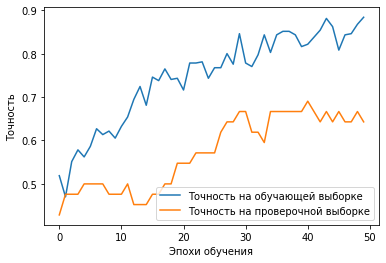

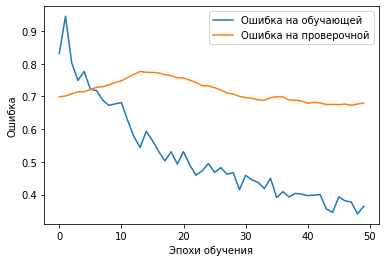

In [247]:
# Создаём пустую сеть при помощи функции createModel()
model = Model_cl()

# Обучаем сеть
history = model.fit(X_train,         
          Y_train,         
          batch_size=12,    # Размер батча
          epochs=50,      # Количество эпох
          validation_data= (X_test, Y_test),
          verbose=1)       # Выводить процесс обучения на каждой эпохе

plt.plot(history.history['accuracy'], label='Точность на обучающей выборке')
plt.plot(history.history['val_accuracy'], label ='Точность на проверочной выборке')
plt.xlabel('Эпохи обучения')
plt.ylabel('Точность')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label ='Ошибка на обучающей')
plt.plot(history.history['val_loss'], label ='Ошибка на проверочной')
plt.xlabel('Эпохи обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()